In [2]:
import os
import splitfolders
import pandas as pd
import tensorflow as tf
import matplotlib as mlp
import matplotlib.pyplot as plt
from glob import glob
from keras import layers, models
from keras.models import load_model
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

In [4]:
splitfolders.ratio('./fruit_dataset/apple', './apple_dataset', seed=1337, ratio=(0.70, 0.25, 0.05))

Copying files: 2286 files [00:13, 167.50 files/s]


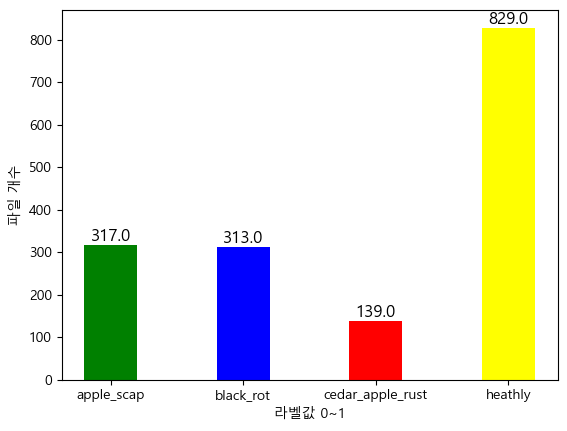

In [9]:
mlp.rcParams["font.family"] = "Malgun Gothic" # 한글 깨짐 방지

train_path = glob("./apple_dataset/train/*")
file_cnt = [len(os.listdir(path)) for path in train_path] # 파일 개수 리스트화
labels = ["apple_scap", "black_rot", "cedar_apple_rust", "heathly"] # 라벨값

bar = plt.bar(labels, file_cnt, width=0.4, color = ["green", "blue", "red", "yellow"]) # barplot
plt.xlabel("라벨값 0~1")
plt.ylabel("파일 개수")

for rect in bar: # barplot 위에 숫자 표시하기
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
    
plt.show()

In [11]:
apple_scap = os.listdir("./apple_dataset/train/apple scab/")
black_rot = os.listdir("./apple_dataset/train/black rot/")
healthy = os.listdir("./apple_dataset/train/healthy/")

for i in range(178):
    os.remove(f"./apple_dataset/train/apple scab/{apple_scap[i]}")
    
for i in range(174):
    os.remove(f"./apple_dataset/train/black rot/{black_rot[i]}")

for i in range(690):
    os.remove(f"./apple_dataset/train/healthy/{healthy[i]}")

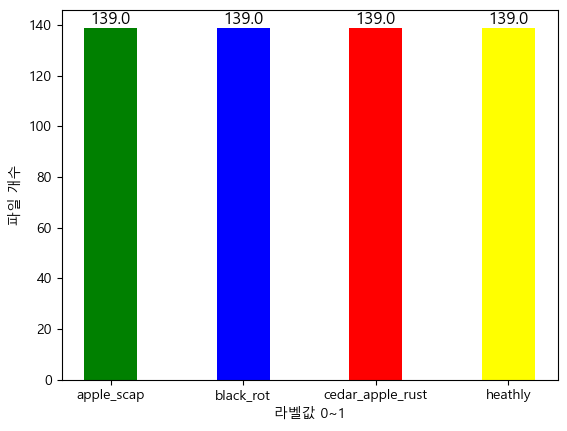

In [12]:
mlp.rcParams["font.family"] = "Malgun Gothic" # 한글 깨짐 방지

train_path = glob("./apple_dataset/train/*")
file_cnt = [len(os.listdir(path)) for path in train_path] # 파일 개수 리스트화
labels = ["apple_scap", "black_rot", "cedar_apple_rust", "heathly"] # 라벨값

bar = plt.bar(labels, file_cnt, width=0.4, color = ["green", "blue", "red", "yellow"]) # barplot
plt.xlabel("라벨값 0~1")
plt.ylabel("파일 개수")

for rect in bar: # barplot 위에 숫자 표시하기
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
    
plt.show()

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255.,
    width_shift_range=0.1,
    rotation_range=45
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255.
)

In [18]:
train_dataset = train_datagen.flow_from_directory(
    "./apple_dataset/train/",
    batch_size=16,
    color_mode="rgb",
    class_mode="categorical"
)

Found 556 images belonging to 4 classes.


In [19]:
test_dataset = train_datagen.flow_from_directory(
    "./apple_dataset/test/",
    batch_size=16,
    color_mode="rgb",
    class_mode="categorical"
)

Found 118 images belonging to 4 classes.


In [20]:
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), input_shape = (256, 256, 3), activation="relu"))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(4, activation="softmax"))

model.compile(optimizer="adam", loss = "categorical_crossentropy", metrics=['acc'])

In [ ]:
model.fit(train_dataset, epochs=15, )